# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 3000-4000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 

Same as CNN 118 but switch cell line 1 to 7.   


In [230]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 16:27:48.235763
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [231]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=3000
MAXLEN=4000   

In [232]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [233]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [234]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=7
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 7 = NCI.H460


## Data Load

In [235]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [236]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 16:27:50.676084
Load RCI values...
Num RCI: 8441
Example RCI: [('ENSG00000000003', -0.26651), ('ENSG00000000419', -0.496772), ('ENSG00000000457', -0.250651)]
Load genes...
2022-12-29 16:27:50.709624
Load sequence...
2022-12-29 16:27:58.886287
Num IDs: 4866
Example IDs: [('ENSG00000197530', 'ENST00000378708.5'), ('ENSG00000069424', 'ENST00000669250.1'), ('ENSG00000171680', 'ENST00000673471.2'), ('ENSG00000132879', 'ENST00000376770.5')]
Count 2092 ones out of 4866 labels.
Example labels: [0, 0, 0, 0]
Num counts: 4866
Example sequence: [158, 117, 210, 72, 30, 118, 213, 84, 79, 60, 239, 185, 227, 139, 42, 166, 150, 86, 85, 83, 76, 46, 183, 219, 107, 171, 170, 165, 147, 74, 38, 149, 82, 70, 24, 95, 122, 230, 151, 92, 111, 186, 230, 152, 95, 124, 240, 191, 251, 233, 161, 131, 12, 48, 191, 250, 230, 152, 94, 120, 223, 122, 230, 149, 84, 79, 58, 232, 159, 123, 235, 170, 166, 150, 88, 95, 122, 232, 159, 124, 238, 182, 216, 95, 123, 235, 170, 166, 152, 94, 117, 211, 74, 38, 152, 94, 1

## Model

In [237]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [238]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 16:27:58.929156
COMPILE
Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_118 (Embedding)   (None, 3997, 4)           1028      
                                                                 
 conv1d_118 (Conv1D)         (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d_10  (None, 64)               0         
 5 (GlobalAveragePooling1D)                                      
                                                                 
 dense_235 (Dense)           (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [239]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 16:27:59.155419
2022-12-29 16:27:59.155600
splitting
Fold 1
Training example
[ 95 123 235 ...   0   0   0]
Train sizes (3972, 3997) (3972, 1)
Valid sizes (894, 3997) (894, 1)
Train set ones/size 1701 / 3972
Valid set ones/size 391 / 894
BUILD MODEL
COMPILE
FIT
2022-12-29 16:28:00.382724
Epoch 1/5
125/125 [==============================] - 2s 10ms/step - loss: 0.6824 - accuracy: 0.5718 - val_loss: 0.6829 - val_accuracy: 0.5626
Epoch 2/5
125/125 [==============================] - 1s 7ms/step - loss: 0.6751 - accuracy: 0.5690 - val_loss: 0.6771 - val_accuracy: 0.5503
Epoch 3/5
125/125 [==============================] - 1s 7ms/step - loss: 0.6676 - accuracy: 0.5740 - val_loss: 0.6752 - val_accuracy: 0.5638
Epoch 4/5
125/125 [==============================] - 1s 7ms/step - loss: 0.6598 - accuracy: 0.5871 - val_loss: 0.6779 - val_accuracy: 0.5559
Epoch 5/5
125/125 [==============================] - 1s 7ms/step - loss: 0.6429 - accuracy: 0.6173 - val_loss: 0.6644 - val_accuracy: 0.

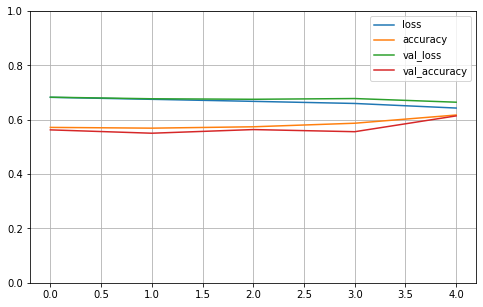

Compute valiation accuracy
2022-12-29 16:28:06.179084
Range of scores: 0.058974266 to 0.83563876
Predicted zeros and ones 536 358
Accuracy: 61.41% Precision: 56.42% Recall: 51.66% F1: 53.94%
2022-12-29 16:28:06.428676
Fold 2
Training example
[ 95 123 235 ...   0   0   0]
Train sizes (3822, 3997) (3822, 1)
Valid sizes (1044, 3997) (1044, 1)
Train set ones/size 1657 / 3822
Valid set ones/size 435 / 1044
BUILD MODEL
COMPILE
FIT
2022-12-29 16:28:07.597987
Epoch 1/5
120/120 [==============================] - 2s 9ms/step - loss: 0.6846 - accuracy: 0.5665 - val_loss: 0.6774 - val_accuracy: 0.5833
Epoch 2/5
120/120 [==============================] - 1s 7ms/step - loss: 0.6786 - accuracy: 0.5657 - val_loss: 0.6680 - val_accuracy: 0.5795
Epoch 3/5
120/120 [==============================] - 1s 7ms/step - loss: 0.6700 - accuracy: 0.5670 - val_loss: 0.6656 - val_accuracy: 0.5843
Epoch 4/5
120/120 [==============================] - 1s 8ms/step - loss: 0.6609 - accuracy: 0.5788 - val_loss: 0.6617 - v

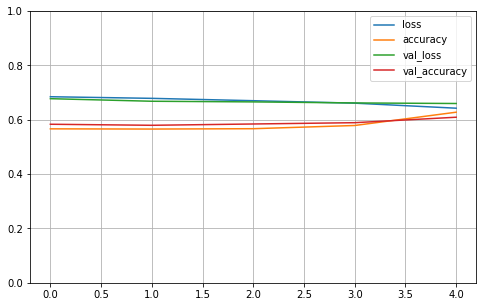

Compute valiation accuracy
2022-12-29 16:28:13.510284
Range of scores: 0.1292239 to 0.84715545
Predicted zeros and ones 897 147
Accuracy: 60.92% Precision: 59.18% Recall: 20.00% F1: 29.90%
2022-12-29 16:28:13.767344
Fold 3
Training example
[ 95 123 235 ...   0   0   0]
Train sizes (3869, 3997) (3869, 1)
Valid sizes (997, 3997) (997, 1)
Train set ones/size 1644 / 3869
Valid set ones/size 448 / 997
BUILD MODEL
COMPILE
FIT
2022-12-29 16:28:14.945232
Epoch 1/5
121/121 [==============================] - 2s 9ms/step - loss: 0.6831 - accuracy: 0.5751 - val_loss: 0.6862 - val_accuracy: 0.5507
Epoch 2/5
121/121 [==============================] - 1s 7ms/step - loss: 0.6761 - accuracy: 0.5751 - val_loss: 0.6786 - val_accuracy: 0.5527
Epoch 3/5
121/121 [==============================] - 1s 7ms/step - loss: 0.6703 - accuracy: 0.5704 - val_loss: 0.6740 - val_accuracy: 0.5657
Epoch 4/5
121/121 [==============================] - 1s 7ms/step - loss: 0.6658 - accuracy: 0.5738 - val_loss: 0.6672 - val_ac

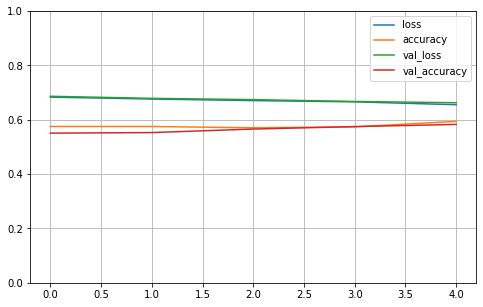

Compute valiation accuracy
2022-12-29 16:28:20.381473
Range of scores: 0.15422782 to 0.592036
Predicted zeros and ones 945 52
Accuracy: 58.27% Precision: 80.77% Recall: 9.38% F1: 16.80%
2022-12-29 16:28:20.648854
Fold 4
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (3886, 3997) (3886, 1)
Valid sizes (980, 3997) (980, 1)
Train set ones/size 1659 / 3886
Valid set ones/size 433 / 980
BUILD MODEL
COMPILE
FIT
2022-12-29 16:28:21.835955
Epoch 1/5
122/122 [==============================] - 2s 9ms/step - loss: 0.6803 - accuracy: 0.5736 - val_loss: 0.6863 - val_accuracy: 0.5582
Epoch 2/5
122/122 [==============================] - 1s 8ms/step - loss: 0.6730 - accuracy: 0.5700 - val_loss: 0.6850 - val_accuracy: 0.5398
Epoch 3/5
122/122 [==============================] - 1s 8ms/step - loss: 0.6676 - accuracy: 0.5733 - val_loss: 0.6835 - val_accuracy: 0.5500
Epoch 4/5
122/122 [==============================] - 1s 7ms/step - loss: 0.6605 - accuracy: 0.5844 - val_loss: 0.6786 - val_accur

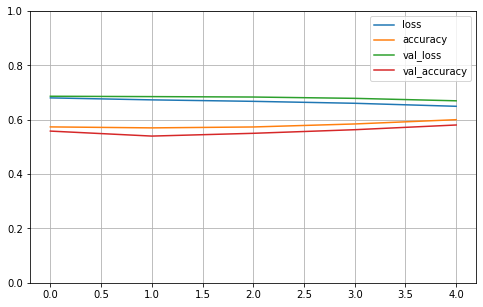

Compute valiation accuracy
2022-12-29 16:28:27.726002
Range of scores: 0.21263163 to 0.7738859
Predicted zeros and ones 528 452
Accuracy: 58.06% Precision: 52.43% Recall: 54.73% F1: 53.56%
2022-12-29 16:28:27.910776
Fold 5
Training example
[ 95 123 235 ...   0   0   0]
Train sizes (3915, 3997) (3915, 1)
Valid sizes (951, 3997) (951, 1)
Train set ones/size 1707 / 3915
Valid set ones/size 385 / 951
BUILD MODEL
COMPILE
FIT
2022-12-29 16:28:29.105447
Epoch 1/5
123/123 [==============================] - 2s 10ms/step - loss: 0.6850 - accuracy: 0.5632 - val_loss: 0.6723 - val_accuracy: 0.5952
Epoch 2/5
123/123 [==============================] - 1s 8ms/step - loss: 0.6797 - accuracy: 0.5586 - val_loss: 0.6641 - val_accuracy: 0.6036
Epoch 3/5
123/123 [==============================] - 1s 7ms/step - loss: 0.6734 - accuracy: 0.5576 - val_loss: 0.6547 - val_accuracy: 0.6015
Epoch 4/5
123/123 [==============================] - 1s 7ms/step - loss: 0.6656 - accuracy: 0.5773 - val_loss: 0.6486 - val_a

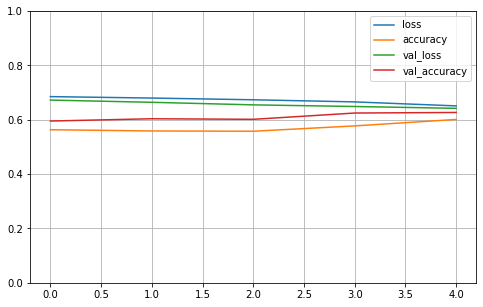

Compute valiation accuracy
2022-12-29 16:28:34.720399
Range of scores: 0.04147374 to 0.8516979
Predicted zeros and ones 507 444
Accuracy: 62.67% Precision: 53.38% Recall: 61.56% F1: 57.18%
2022-12-29 16:28:34.965434

Cross validation 5 folds 5 epochs
 accuracy mean 60.27% +/- 1.81
 precision mean 60.44% +/- 10.44
 recall mean 39.47% +/- 20.76
 F1 mean 42.27% +/- 16.05
2022-12-29 16:28:34.967663


In [240]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())